In [329]:
from __future__ import division, print_function, absolute_import

import os
import math
from matplotlib import pyplot as plt

import numpy as np

%matplotlib inline

In [330]:
def read_detection_file(detection_file_path):
    detection_file = open(detection_file_path, 'r')
    detection_lines = detection_file.readlines()
    detection_file.close()
    
    detections = []
    detections_frame = {}

    for line in detection_lines:
        line = line.strip()

        if line[:5] == 'frame':
            detections.append(detections_frame)
            detections_frame = {}
            continue

        if line[:5] == 'track':
            track_id = line[line.find(':') + 1 : line.find(' ')]
            info = [float(item) for item in line[line.find(' ') + 1 : ].split(' ')]
            detections_frame[track_id] = info
            continue

    detections = detections[1:]
    
    return detections

In [331]:
def centroid(coords):
    return [(coords[0] + coords[2]) / 2, (coords[1] + coords[3]) /2]

In [332]:
def build_track_centroids_list(detections):
    track_centroids = {}

    for detections_frame in detections:   
        for track_id, coords in detections_frame.items():
            if not track_id in track_centroids.keys():
                track_centroids[track_id] = []
            else:
                track_centroids[track_id].append(centroid(coords))

    return track_centroids

In [333]:
def linreg(pts):
    X = [coord[0] for coord in pts]
    Y = [coord[1] for coord in pts]
    N = len(X)
    if N < 2:
        return 0, 0
    Sx = Sy = Sxx = Syy = Sxy = 0.0
    for x, y in zip(X, Y):
        Sx = Sx + x
        Sy = Sy + y
        Sxx = Sxx + x*x
        Syy = Syy + y*y
        Sxy = Sxy + x*y
    det = Sxx * N - Sx * Sx
    if det == 0:
        print(pts)
    return (Sxy * N - Sy * Sx)/det, (Sxx * Sy - Sx * Sxy)/det

In [334]:
def build_track_trend(track_centroids_dict):
    linregs = []
    track_trends = {}

    for track_id, centroids in track_centroids_dict.items():
        if len(track_centroids_dict[track_id]) > 1:
            track_trends[track_id] = linreg(centroids)
    
    return track_trends

In [335]:
def filter_trends(track_trends, track_centroids, window_total_ratio, min_window_size, max_trend_slope_change):
    tracks_filtered = []
    trends_filtered = []

    for track_id, trend in track_trends.items():
        reliable = True

        trend_slope = math.degrees(math.atan(track_trends[track_id][0]))
        centroids = track_centroids[track_id]
        
        total = len(centroids)
        window = int(total * window_total_ratio)
        
        # Obj must be detected for more than total*window_total_ratio frames
        if window < min_window_size:
            reliable = False
        
        index = 0
        while reliable:
            if(index + window > len(centroids) - 1):
                break
                
            test_centroids = centroids[index: index + window - 1]            
            test_trend = linreg(test_centroids)
            test_trend_slope = math.degrees(math.atan(test_trend[0]))
            if abs(test_trend_slope - trend_slope) > max_trend_slope_change:
                '''
                print('track:'+track_id)
                print(test_trend_slope)
                print(trend_slope)
                print(abs(test_trend_slope - trend_slope))
                reliable = False
                '''
            index += window

        if reliable:
            tracks_filtered.append(track_id)
            trends_filtered.append(trend)

    return tracks_filtered, trends_filtered

In [336]:
def plot_trends(tracks, trends):
    plt.figure(figsize=(16,9))

    plt.ylim(ymax=0)
    plt.ylim(ymin=720)
    plt.xlim(xmax=1280)
    plt.xlim(xmin=0)

    axes = plt.gca()
    x = np.array(axes.get_xlim())

    for s, i in trends[:]:
        plt.plot(x, s * x + i)

    plt.legend(tracks[:])

    plt.show()

In [337]:
def normalize_trend(trends, img_width, img_height):
    trends = np.array(trends)
    #trends[:, 1] = trends[:, 1] - img_width / 2 # move origin to bottom centre
    trends[:, 1] = trends[:, 1] / trends[:, 0] # norm. against slope
    trends[:, 0] = trends[:, 0] / trends[:, 1] # norm. against normalized intersection
    '''
    trends[:, 0] = trends[:, 0] / np.linalg.norm(trends[:, 0])
    trends[:, 1] = trends[:, 1] / np.linalg.norm(trends[:, 1]) #img_height 
    '''
    return trends

In [366]:
def merge_trends_to_lanes(trends, max_slope_diff, max_x_intersection_diff):
    trends = np.array(trends)
    lanes = [trends[0]]
    new_lane = True
    for trend in trends:
        for index, lane in zip(range(len(lanes)), lanes):
            if abs(math.degrees(math.atan(trend[0])) - math.degrees(math.atan(lane[0]))) < max_slope_diff\
            and abs(trend[1]/trend[0] - lane[1]/lane[0]) / (abs(lane[0]) + abs(trend[0]))/2 < max_x_intersection_diff:
                lane = (lane + trend) / 2 ### <- try use weighted average instead
                lanes[index] = lane
                new_lane = False
                break
        if new_lane == True:
            lanes.append(trend)
            print(abs(math.degrees(math.atan(trend[0])) - math.degrees(math.atan(lane[0]))))
            print(abs(trend[1]/trend[0] - lane[1]/lane[0]) / (abs(lane[0]) + abs(trend[0]))/2)
        new_lane = True
    return lanes

In [370]:
DETECTION_FILE_PATH = "./detection.txt"

IMG_W = 1280
IMG_H = 720

WINDOW_TOTAL_RATIO = 0.25
MIN_WINDOW_SIZE = 5
MAX_TREND_SLOPE_CHANGE = 20

MAX_SLOPE_DIFF = 10
MAX_X_INTERSECTION_DIFF = 60

detections = read_detection_file(DETECTION_FILE_PATH)
track_centroids = build_track_centroids_list(detections)
track_trends = build_track_trend(track_centroids)
tracks_filtered, trends_filtered = filter_trends(track_trends, track_centroids,
                                                 WINDOW_TOTAL_RATIO, 
                                                 MIN_WINDOW_SIZE, 
                                                 MAX_TREND_SLOPE_CHANGE)
#trends_normalized = normalize_trend(trends_filtered, IMG_W, IMG_H)
lanes = merge_trends_to_lanes(trends_filtered, MAX_SLOPE_DIFF, MAX_X_INTERSECTION_DIFF)

113.16458111272692
4.236666737974581
65.39128108150234
58.923007883397034
69.01891283832285
130.4203786865398
99.71884265946699
38.143634273939206
11.265715976297216
14.392686045255981
25.48176715182601
411.9020002640231
24.588148604277
140.29324087057606
26.43765479901258
256.6298575336506
65.65105511879693
521.8129771280537
10.78750230344125
66.41845145852035


In [371]:
lanes

[array([  -3.43980225, 2021.0695663 ]),
 array([   0.68859551, -302.73436739]),
 array([ -0.55521864, 430.72334719]),
 array([   0.75676362, -314.00650473]),
 array([ -1.60909991, 983.35514849]),
 array([ -0.9241885 , 628.07187548]),
 array([-3.39457350e-01,  6.06213725e+02]),
 array([-9.04693679e-01,  1.25789941e+03]),
 array([-2.81045712e-01,  5.61812343e+02]),
 array([   1.18978133, -552.07485624]),
 array([    1.78495372, -1533.57567104])]

/Users/mengwan/anaconda/envs/SSD/lib/python3.6/site-packages/matplotlib/axes/_base.py:3285: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0
  'bottom=%s, top=%s') % (bottom, top))


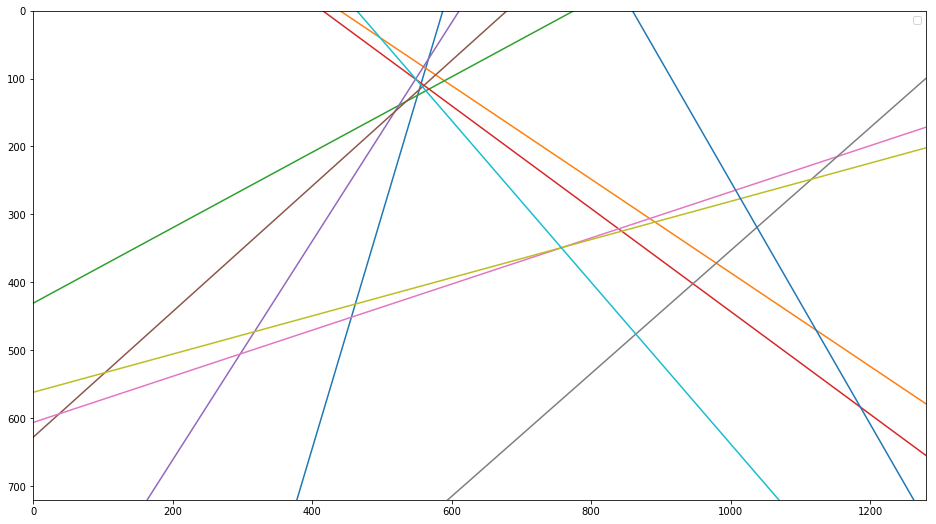

In [372]:
plot_trends([], lanes)

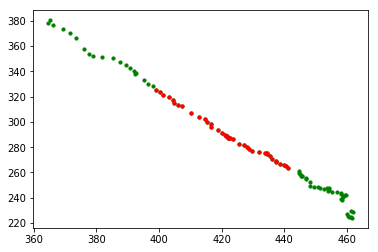

In [133]:
cntroids = track_centroids['11']
test_centroids = cntroids[20:60]

test_X = [c[0] for c in test_centroids]
test_Y = [c[1] for c in test_centroids]
X = [c[0] for c in centroids]
Y = [c[1] for c in centroids]

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(X, Y, s=10, c='g')
ax1.scatter(test_X, test_Y, s=10, c='r')
plt.show()

/Users/mengwan/anaconda/envs/SSD/lib/python3.6/site-packages/matplotlib/axes/_base.py:3285: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0
  'bottom=%s, top=%s') % (bottom, top))


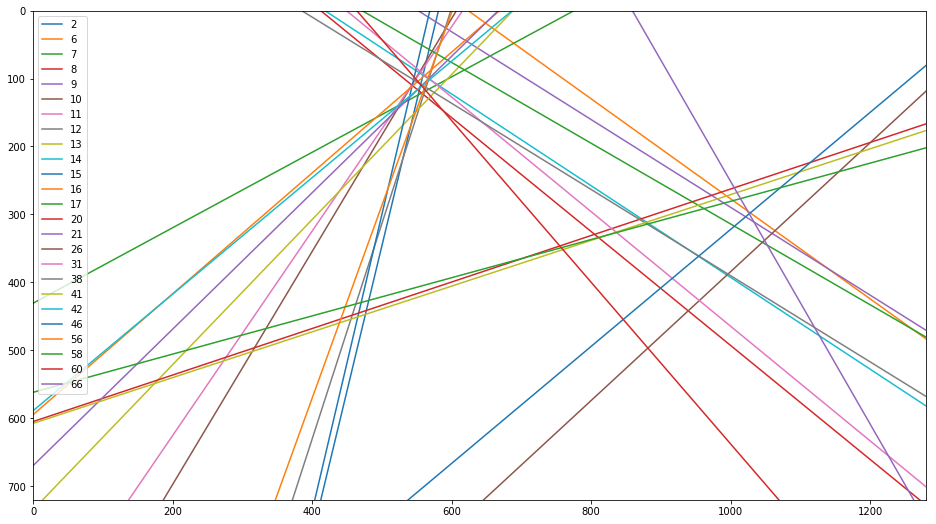

In [300]:
plot_trends(tracks_filtered, trends_filtered)

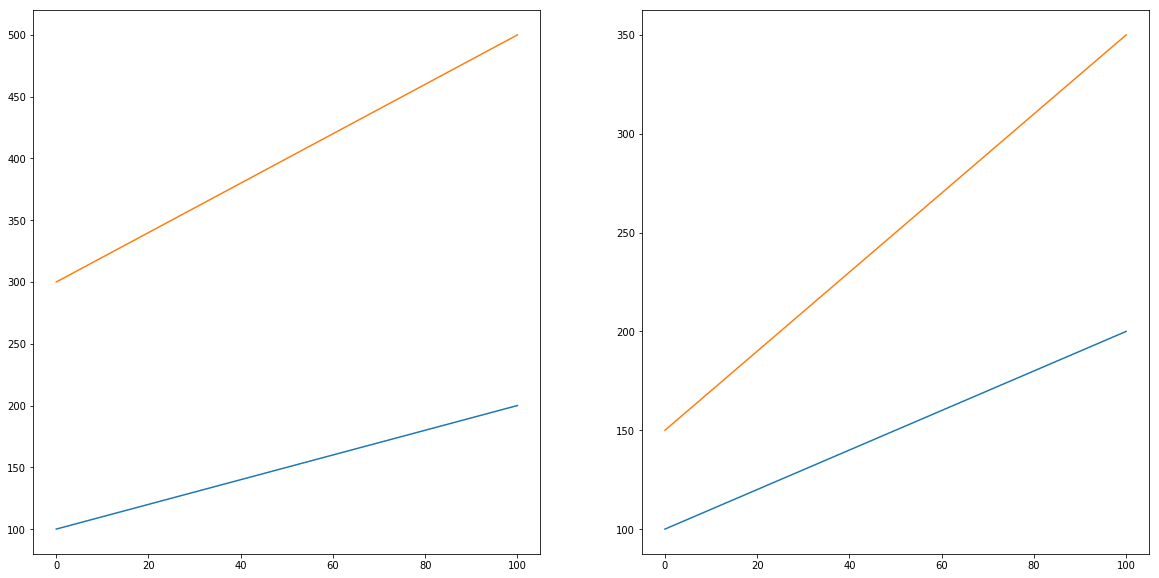

In [309]:
plt.figure(figsize=(20,10))

plt.ylim(ymin=0)
plt.ylim(ymax=100)
plt.xlim(xmin=0)
plt.xlim(xmax=100)

axes = plt.gca()
x = np.array(axes.get_xlim())

s1 = 1
i1 = 100
s2 = 2
i2 = 300

plt.subplot(121)
plt.plot(x, s1 * x + i1)
plt.plot(x, s2 * x + i2)

i1n = i1 / s1
i2n = i2 / s2
s1n = s1
s2n = s2

plt.subplot(122)
plt.plot(x, s1n * x + i1n)
plt.plot(x, s2n * x + i2n)

plt.show()

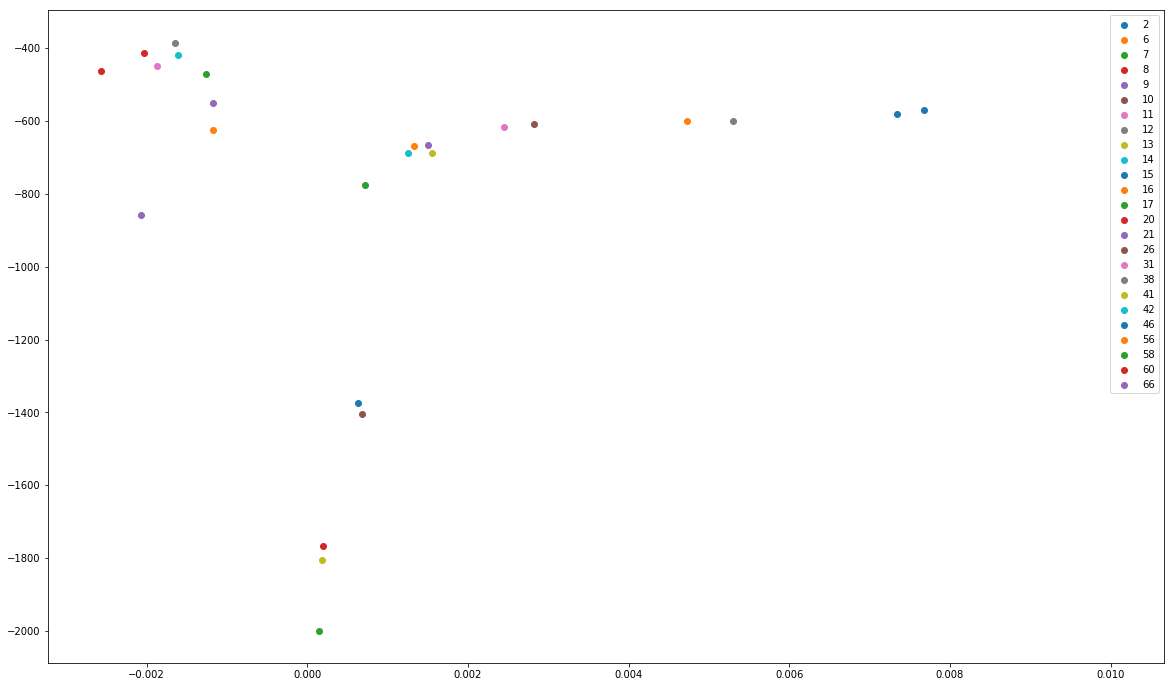

In [310]:
plt.figure(figsize=(20,12))
X = trends_normalized[:, 0]
Y = trends_normalized[:, 1]

legends = []
for x, y, track in zip(X, Y, tracks_filtered):
    #if track == '2' or track == '12' or track == '15' or track == '14' or track == '17' or track == '11'  or track == '42':
    plt.scatter(x, y)
    legends.append(track)

plt.legend(legends)
#plt.legend(tracks_filtered)

plt.show()